### GNN

<div class="alert alert-block alert-info">
    This is an implementation from the <a href="https://github.com/chirag126/nifty">NIFTY</a> project on HELOC dataset as implemented by <a href="https://github.com/alessandrofogli">@alefog</a> with additional preprocessing.
</div>

In [1]:
import random
import numpy as np

np.random.seed(0)

import pandas as pd
import requests
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy.spatial import distance_matrix
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import NearestNeighbors
from torch_geometric.nn import GINConv
from torch_geometric.utils import convert
from typing import Tuple

<h4>Preprocessing</h4>

In [2]:
threshold = 0.10
knn_k = 5

In [3]:
def build_relationship(x, thresh=threshold):
    df_euclid = pd.DataFrame(
        1 / (1 + distance_matrix(x.T.T, x.T.T)), columns=x.T.columns, index=x.T.columns
    )
    df_euclid = df_euclid.to_numpy()
    idx_map = []
    for ind in range(df_euclid.shape[0]):
        max_sim = np.sort(df_euclid[ind, :])[-2]
        neig_id = np.where(df_euclid[ind, :] > thresh * max_sim)[0]
        random.seed(0)
        random.shuffle(neig_id)
        for neig in neig_id:
            if neig != ind:
                idx_map.append([ind, neig])
    idx_map = np.array(idx_map)
    return idx_map


def build_relationship_knn(x, k):
    nn = NearestNeighbors(n_neighbors=k + 1, metric="euclidean")
    nn.fit(x)
    distances, indices = nn.kneighbors(x)
    idx_map = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors[1:]:
            idx_map.append([i, neighbor])
    return np.array(idx_map)


def load_dataset(dataset, edges, predict_attr, path):
    idx_features_labels = pd.read_csv(dataset)
    # make more generic with label binarizer
    idx_features_labels.replace(
        {"RiskPerformance": {"Bad": 1, "Good": 0}}, inplace=True
    )
    header = list(idx_features_labels.columns)
    header.remove(predict_attr)

    edges_unordered = requests.get(edges)
    edges_unordered = np.array(edges_unordered.text)
    edges_unordered = build_relationship_knn(idx_features_labels[header], k=knn_k)

    features = sp.csr_matrix(idx_features_labels[header], dtype=np.float32)

    labels = idx_features_labels[predict_attr].values
    idx = np.arange(features.shape[0])
    idx_map = {j: i for i, j in enumerate(idx)}
    
    edges = np.array(
        list(map(idx_map.get, edges_unordered.flatten())), dtype=int
    ).reshape(edges_unordered.shape)
    adj = sp.coo_matrix(
        (np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
        shape=(labels.shape[0], labels.shape[0]),
        dtype=np.float32,
    )
    
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
    adj = adj + sp.eye(adj.shape[0])
    
    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(labels)
    
    random.seed(0)
    label_idx_0 = np.where(labels == 0)[0]
    label_idx_1 = np.where(labels == 1)[0]
    random.shuffle(label_idx_0)
    random.shuffle(label_idx_1)
        
    num_label_1_test = int(label_idx_1.size * 0.3)
    num_label_0_test = int(label_idx_0.size * 0.3)
    num_label_1_train = label_idx_1.size - num_label_1_test
    num_label_0_train = label_idx_0.size - num_label_0_test
    idx_train_1 = label_idx_1[:num_label_1_train]
    idx_test_1 = label_idx_1[num_label_1_train : num_label_1_train + num_label_1_test]
    idx_train_0 = label_idx_0[:num_label_0_train]
    idx_test_0 = label_idx_0[num_label_0_train : num_label_0_train + num_label_0_test]
    idx_train = np.concatenate((idx_train_0, idx_train_1))
    idx_test = np.concatenate((idx_test_0, idx_test_1))
    
    random.seed(90)
    random.shuffle(idx_train)
    random.shuffle(idx_test)
    
    idx_train = torch.LongTensor(idx_train)
    idx_test = torch.LongTensor(idx_test)
    
    return adj, features, labels, idx_train, idx_test

<h4>Load data</h4>

In [4]:
# Load data
predict_attr = "RiskPerformance"
path_heloc = (
    "https://raw.githubusercontent.com/alessandrofogli/"
    "Exploring-the-Potential-of-Graph-Neural-Networks-for-Credit-Scoring"
    "/main/data/FICO"
)
adj, features, labels, idx_train, idx_test = load_dataset(
    f"{path_heloc}/heloc.csv",
    f"{path_heloc}/heloc_edges.txt",
    predict_attr,
    path=path_heloc
)

<h4>Setup device</h4>

In [5]:
seed = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

<h4>Feature preprocessing (XGBoost)</h4>

In [6]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier

In [7]:
X = pd.DataFrame(features.numpy().copy())
X.columns = [f"feature_{i+1}" for i in range(len(X.columns))]
y = pd.Series(labels.numpy().copy())

idx_train_xgb, idx_test_xgb = train_test_split(
    X.index,
    stratify=y,
    test_size=0.3,
    random_state=0
)

In [8]:
n_estimators = 100

xgb_model = XGBClassifier(
    n_estimators=n_estimators, 
    max_depth=7,
    learning_rate=0.3,
    base_score=0.5,
    tree_method="hist", 
    objective="binary:logistic",
    max_leaves=5,
    reg_alpha=50,
    reg_lambda=30,
    colsample_bytree=0.5,
    n_jobs=3, 
    random_state=0
)

xgb_model.fit(features[idx_train_xgb], labels[idx_train_xgb])

auc_score = roc_auc_score(
    labels[idx_train_xgb],
    xgb_model.predict_proba(features[idx_train_xgb])[:, 1]
)
print(auc_score*2-1)

auc_score = roc_auc_score(
    labels[idx_test_xgb],
    xgb_model.predict_proba(features[idx_test_xgb])[:, 1]
)
print(auc_score*2-1)

0.6058592739372641
0.5902047212047212


In [9]:
# Create a list to store the margins for each tree
tree_margins = []

# Tree iteration
for i in range(n_estimators):
    margins = xgb_model.predict(
        X, 
        output_margin=True,
        base_margin=np.zeros(X.shape[0]),
        iteration_range=(i, i+1)
    )
    tree_margins.append(margins)

# Create a DataFrame with the margins for each tree
leaf_predictions = pd.DataFrame(tree_margins).T
leaf_predictions.index = y.index

# Assign column names if needed
leaf_predictions.columns = [f"tree_{i+1}" for i in range(100)]

In [12]:
features_tree = sp.csr_matrix(leaf_predictions, dtype=np.float32)
features_tree = torch.FloatTensor(np.array(features_tree.todense())).to(device)
features_tree = features_tree.to(device)

<h4>Model</h4>

In [13]:
edge_index = convert.from_scipy_sparse_matrix(adj)[0]
edge_index = edge_index.to(device)
num_class = labels.unique().shape[0] - 1
nfeat = features_tree.shape[1] # features.shape[1]
features = features.to(device)
labels = labels.to(device)

In [14]:
class GIN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GIN, self).__init__()

        self.mlp1 = nn.Sequential(
            nn.Linear(nfeat, nhid),
            nn.Sigmoid(), # nn.ReLU(),
            nn.BatchNorm1d(nhid),
            nn.Linear(nhid, nhid),
            nn.Sigmoid(), # nn.ReLU(),
            nn.BatchNorm1d(nhid),
        )
        self.conv1 = GINConv(self.mlp1)
        self.fc = nn.Linear(nhid, nclass)
        self.dropout = nn.Dropout(dropout)

        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.fill_(1.0)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [15]:
def train_and_evaluate(
    model: nn.Module,
    optimizer: optim.Optimizer,
    features: torch.Tensor,
    edge_index: torch.Tensor,
    labels: torch.Tensor,
    idx_train: torch.Tensor,
    idx_test: torch.Tensor,
    device: torch.device,
    num_epochs: int
) -> Tuple[float, float]:
    """
    Train and evaluate the GNN model.

    Args:
        model (torch.nn.Module): The GNN model.
        optimizer (torch.optim.Optimizer): The optimizer.
        features (torch.Tensor): The input features.
        edge_index (torch.Tensor): The edge index tensor.
        labels (torch.Tensor): The ground truth labels.
        idx_train (torch.Tensor): The indices of the training set.
        idx_test (torch.Tensor): The indices of the test set.
        device (torch.device): The device (CPU or GPU) to run the computation.
        num_epochs (int): The number of training epochs.

    Returns:
        Tuple[float, float]: A tuple of the AUC scores for the training and test sets.
    """
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(features, edge_index)
        loss_train = F.binary_cross_entropy_with_logits(
            output[idx_train], labels[idx_train].unsqueeze(1).float().to(device)
        )
        loss_train.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        output_train = model(features, edge_index)[idx_train]
        output_test = model(features, edge_index)[idx_test]

    auc_train = roc_auc_score(
        labels[idx_train].cpu().numpy(), torch.sigmoid(output_train).cpu().numpy()
    )
    auc_test = roc_auc_score(
        labels[idx_test].cpu().numpy(), torch.sigmoid(output_test).cpu().numpy()
    )

    return auc_train, auc_test

In [16]:
import optuna
from optuna.samplers import TPESampler

num_epochs=50

def objective(trial):
    
    # Define the hyperparameters to tune
    dropout = trial.suggest_float('dropout', 0.1, 0.8, step=0.005)
    nhid = trial.suggest_int('nhid', 32, 128)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3)

    # Create the model with the specified hyperparameters
    model = GIN(nfeat, nhid, num_class, dropout)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Train and evaluate the model
    train_score, test_score = [
        (score * 2 - 1) for score in train_and_evaluate(
            model=model,
            optimizer=optimizer,
            features=features_tree, # features
            edge_index=edge_index,
            labels=labels,
            idx_train=idx_train,
            idx_test=idx_test,
            device=device,
            num_epochs=num_epochs
        )
    ]
        
    train_err = 1 - train_score
    test_err = 1 - test_score
    score = test_score * abs(train_err/test_err)

    return score

initial_params = {
    "dropout": 0.5,
    "nhid": 16, 
    "lr": 1e-3,
    "weight_decay": 1e-5
}

sampler = TPESampler(seed=seed)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.enqueue_trial(initial_params)
print("Created new study.")
    
study.optimize(objective, n_trials=20)
best_params = study.best_params
best_gini = study.best_value


[I 2023-11-06 14:46:04,154] A new study created in memory with name: no-name-8b02d7dd-08f9-43e7-9729-81f309d67412
/Users/deburky/Library/Caches/pypoetry/virtualenvs/risk-practitioner-ebook-NcspVTUP-py3.10/lib/python3.10/site-packages/optuna/trial/_trial.py:651: UserWarning: Fixed parameter 'nhid' with value 16 is out of range for distribution IntDistribution(high=128, log=False, low=32, step=1).
  warnings.warn(


Created new study.


[I 2023-11-06 14:46:05,051] Trial 0 finished with value: 0.5759487351427381 and parameters: {'dropout': 0.5, 'nhid': 16, 'lr': 0.001, 'weight_decay': 1e-05}. Best is trial 0 with value: 0.5759487351427381.
[I 2023-11-06 14:46:06,390] Trial 1 finished with value: 0.5632437245550238 and parameters: {'dropout': 0.485, 'nhid': 101, 'lr': 0.0006431172050131992, 'weight_decay': 0.0005453382998139001}. Best is trial 0 with value: 0.5759487351427381.
[I 2023-11-06 14:46:07,652] Trial 2 finished with value: 0.5636536003439161 and parameters: {'dropout': 0.395, 'nhid': 94, 'lr': 0.00020547625125911338, 'weight_decay': 0.0008918812277812978}. Best is trial 0 with value: 0.5759487351427381.
[I 2023-11-06 14:46:08,826] Trial 3 finished with value: 0.571885169456479 and parameters: {'dropout': 0.775, 'nhid': 69, 'lr': 0.0023723300729921923, 'weight_decay': 0.0005293660248331517}. Best is trial 0 with value: 0.5759487351427381.
[I 2023-11-06 14:46:10,267] Trial 4 finished with value: 0.19121811169182

In [17]:
model = GIN(
    nfeat=nfeat,
    nhid=best_params["nhid"],
    nclass=num_class,
    dropout=best_params["dropout"],
)

model.to(device)

# Train model
optimizer = optim.Adam(
    model.parameters(),
    lr=best_params["lr"], 
    weight_decay=best_params["weight_decay"]
)

num_epochs = 87
auc_train, auc_test = train_and_evaluate(
    model=model,
    optimizer=optimizer,
    features=features_tree, # features
    edge_index=edge_index,
    labels=labels,
    idx_train=idx_train,
    idx_test=idx_test,
    device=device,
    num_epochs=num_epochs
)

print(
    f"Train Gini score: {auc_train*2-1:.2%}\n"
    f"Test Gini score: {auc_test*2-1:.2%}"
)

Train Gini score: 57.05%
Test Gini score: 57.04%


<h4> Visualize the graph network </h4>

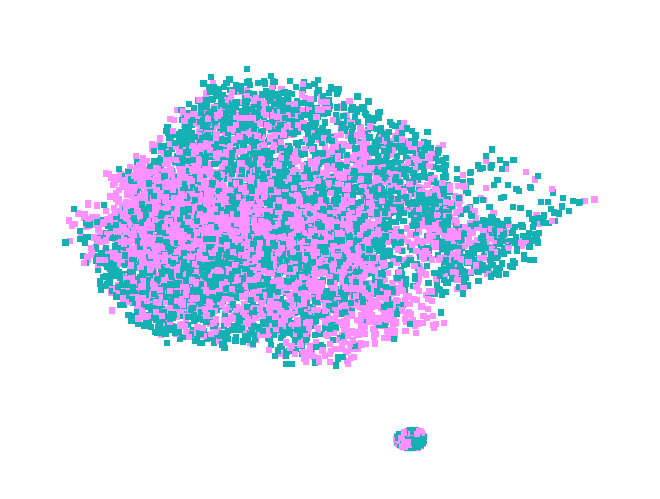

In [15]:
import networkx as nx
from matplotlib import pyplot as plt
%matplotlib inline

# Subsample data for plotting
num_observations = 9000
features_nx = features_woe[:num_observations]
labels_nx = labels[:num_observations]
adj_nx = adj[:num_observations, :num_observations]

# Create a list of node IDs by using the indices of the nodes dataframe
node_ids = list(range(len(features_nx)))
edge_pairs = [tuple(row) for row in adj_nx.toarray()]

# Create a list of node IDs by using the indices of the nodes dataframe
node_ids = list(range(len(features_nx)))
nonzero_indices = adj_nx.nonzero()
edge_pairs = list(zip(nonzero_indices[0], nonzero_indices[1]))

# Create a graph using the node IDs and edge pairs
G = nx.Graph()
G.add_nodes_from(node_ids)
G.add_edges_from(edge_pairs)

node_colors = ['#ff90ff' if label == 1 else '#15b0b3' for label in labels_nx]
 
# Draw the graph
nx.draw(
    G,
    # pos=nx.spring_layout(G),
    with_labels=False,
    node_color=node_colors,
    node_size=20,
    node_shape="s",
    edge_color='white',
    alpha=1.0,
    width=0.01,
    linewidths=0.01
)
# Draw edges
# nx.draw_networkx_edges(
#     G, 
#     pos=nx.spring_layout(G), 
#     style=':',
#     width=1e-5
# )
plt.show()